In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import Polygon, LineString, Point

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

In [2]:
def minmaxscale(array):
    """
    Min-max scaling of data
    """
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))

In [3]:
# county shapefiles
md_counties = gpd.read_file('/Users/molina/Desktop/tl_2021_us_county/tl_2021_us_county.shp')
# select MD
md_counties = md_counties.loc[md_counties['STATEFP']=='24']

In [4]:
# load states high res
scale = '10m'
states10 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='g')

In [5]:
# load uni/school sites
md_schools = pd.read_excel('/Users/molina/Desktop/public_highed_md.xlsx')
# drop nans
md_schools = md_schools.drop(index=[20,31,52])[['sitename','latitude','longitude']]

In [6]:
# precip data from state climatologist
ds_md_prp_std = xr.open_dataset('/Users/molina/Desktop/prec_sd_day2seas_1991-2020.nc', decode_cf=False)
ds_md_prp_std = ds_md_prp_std.sel(lon=slice(-80,-74), lat=slice(37,40)).isel(time=0)

# creat seasonal objects
ds_win = ds_md_prp_std['prcpsdwin'].where(ds_md_prp_std['prcpsdwin']!=-9.999000e+03)
ds_spr = ds_md_prp_std['prcpsdspr'].where(ds_md_prp_std['prcpsdspr']!=-9.999000e+03)
ds_sum = ds_md_prp_std['prcpsdsum'].where(ds_md_prp_std['prcpsdsum']!=-9.999000e+03)
ds_fal = ds_md_prp_std['prcpsdfal'].where(ds_md_prp_std['prcpsdfal']!=-9.999000e+03)

In [7]:
# load state shapefiles
md_state = gpd.read_file('/Users/molina/Desktop/tl_2022_us_state/tl_2022_us_state.shp')
md_state = md_state[md_state['NAME'] == 'Maryland']

# create state mask based on netcdf grid
md_state_mask = np.zeros(ds_win.shape)
for i, j in product(range(ds_win.lat.shape[0]), range(ds_win.lon.shape[0])):
    if md_state.contains(Point(ds_win.lon[j], ds_win.lat[i])).values[0]:
        md_state_mask[i,j] = 1

### load MD shapefiles / demo data

https://data.imap.maryland.gov/datasets/maryland::maryland-census-boundaries-census-block-groups-2020/about
https://data.imap.maryland.gov/datasets/maryland::maryland-census-data-zip-code-tabulation-areas-zctas/about
https://data.imap.maryland.gov/datasets/maryland::maryland-american-community-survey-acs-zip-code-tabulation-areas-zctas/about

In [8]:
# load data from imap
md_zcta_census = gpd.read_file(
    '/Users/molina/Desktop/Maryland_Census_Data_-_ZIP_Code_Tabulation_Areas_(ZCTAs)/DEMO_CensusDataZCTA_MDP.shp')
# print(md_zcta_census.crs)

# convert projection
md_zcta_census = md_zcta_census.to_crs({'init': 'epsg:4326'})
# print(md_zcta_census.crs)

# compute population normalized by land area
md_zcta_census['popnormbyarea'] = md_zcta_census['POP100'] / (md_zcta_census['AREALAND'] / 1000)

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
# load data from imap
md_acs = gpd.read_file(
    '/Users/molina/Desktop/Maryland_American_Community_Survey_-_ACS_ZIP_Code_Tabulation_Areas_(ZCTAs)/'+\
    'DEMO_AmericanCommunitySurveyZCTA_MDP.shp')
# print(md_acs.crs)

# convert projection
md_acs = md_acs.to_crs({'init': 'epsg:4326'})
# print(md_acs.crs)

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Figure creation

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


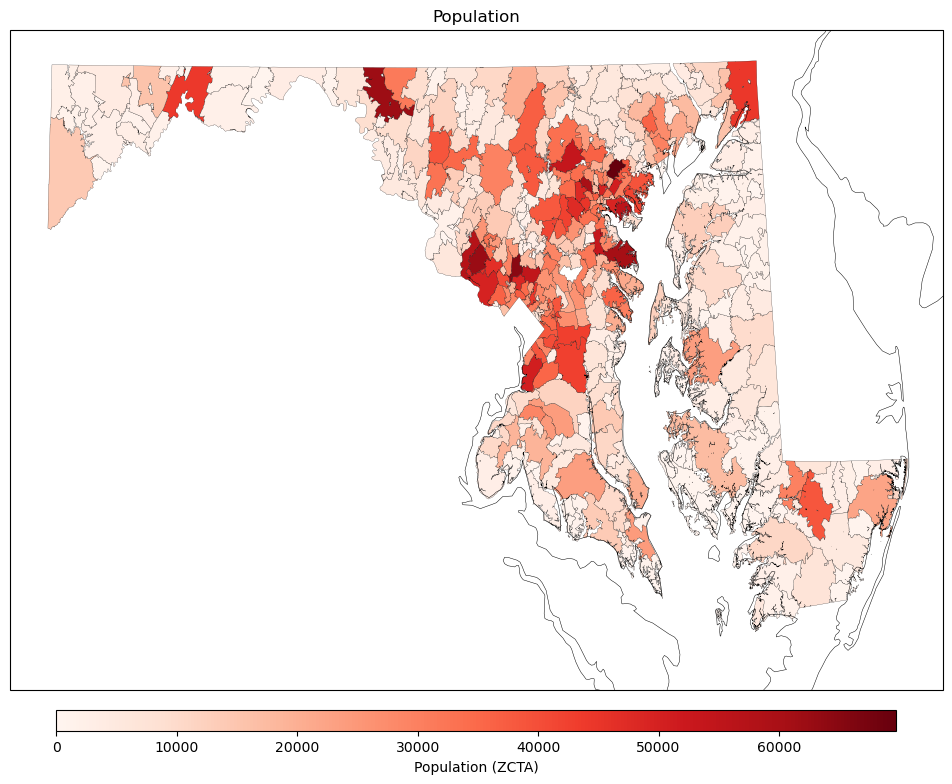

In [10]:
# population
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Population', fontsize=12)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='POP100', cmap='Reds', 
                    legend=True, edgecolor='k', lw=0.15, figsize=(12,8),
                    legend_kwds={'label': 'Population (ZCTA)', "orientation": "horizontal",
                                 'shrink':0.7, 'pad':0.025, 'aspect':40})

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/popmd_md.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


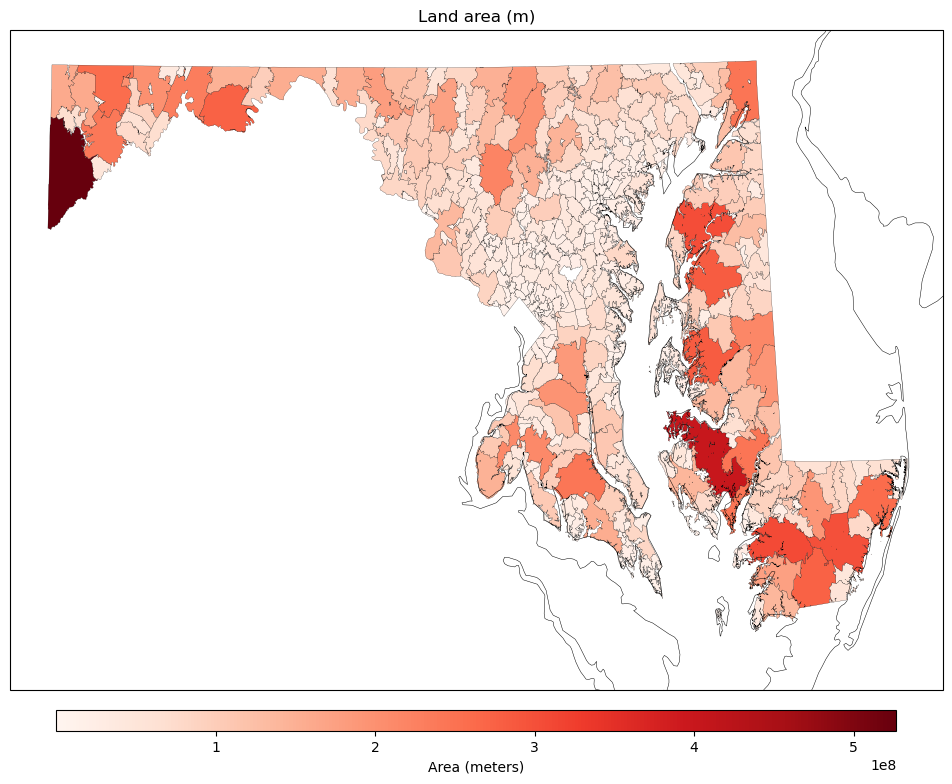

In [11]:
# land area in meters
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Land area (m)', fontsize=12)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='AREALAND', cmap='Reds', 
                    legend=True, edgecolor='k', lw=0.15, figsize=(12,8),
                    legend_kwds={'label': 'Area (meters)', "orientation": "horizontal",
                                 'shrink':0.7, 'pad':0.025, 'aspect':40})

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/arealand_md.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


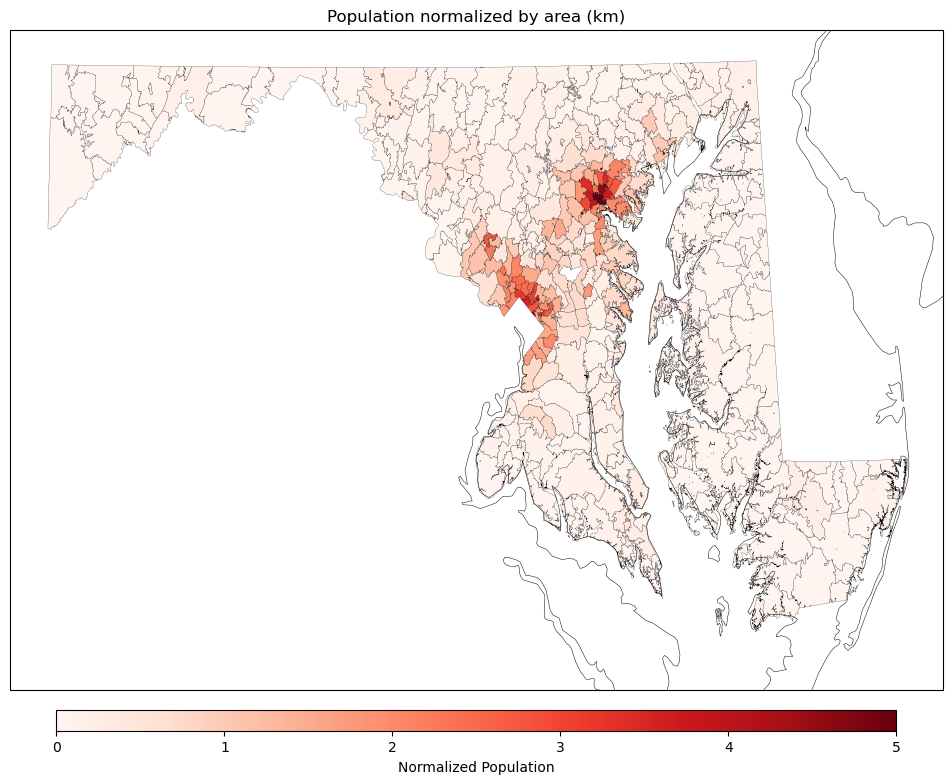

In [12]:
# population normalized by land area (km)
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Population normalized by area (km)', fontsize=12)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='popnormbyarea', cmap='Reds', 
                    legend=True, edgecolor='k', lw=0.15, figsize=(12,8), vmin=0, vmax=5, 
                    legend_kwds={'label': 'Normalized Population', "orientation": "horizontal",
                                 'shrink':0.7, 'pad':0.025, 'aspect':40})

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/normpop_md.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


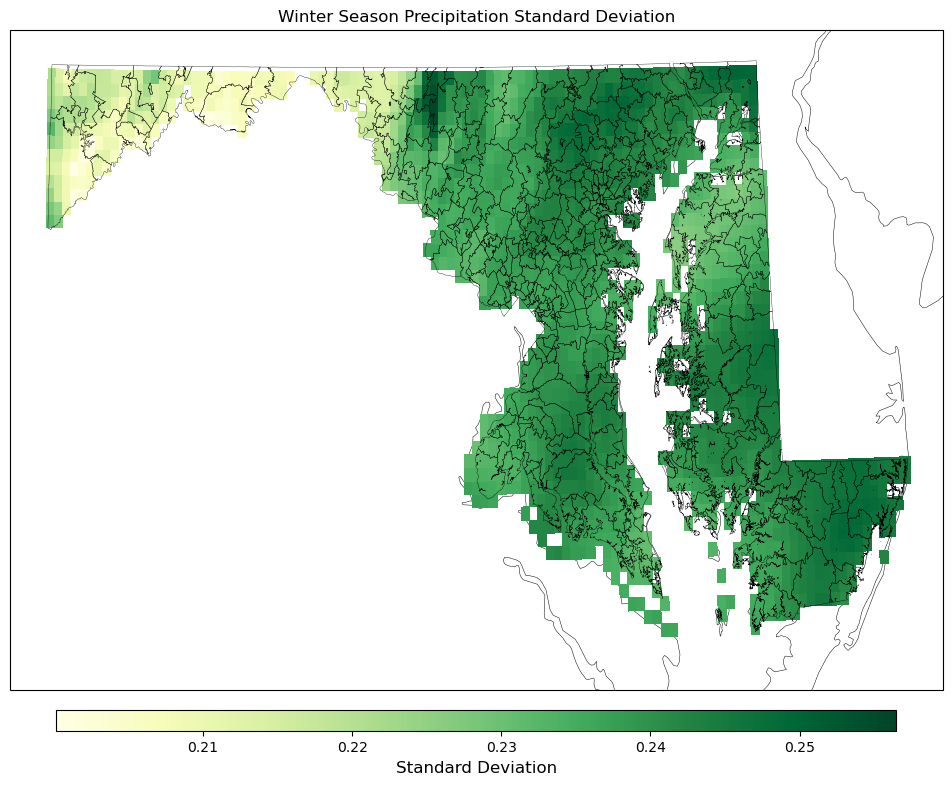

In [13]:
# winter pcp std
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Winter Season Precipitation Standard Deviation', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   ds_win.where(md_state_mask==1).values, 
                   vmin=ds_win.where(md_state_mask==1).min(skipna=True).values, 
                   vmax=ds_win.where(md_state_mask==1).max(skipna=True).values, 
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=10)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Standard Deviation', fontsize=12)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=True, facecolor='none', edgecolor='k', lw=0.25, zorder=100)

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
#ax.add_feature(states10, facecolor='none', edgecolor='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/pcpstd_win.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


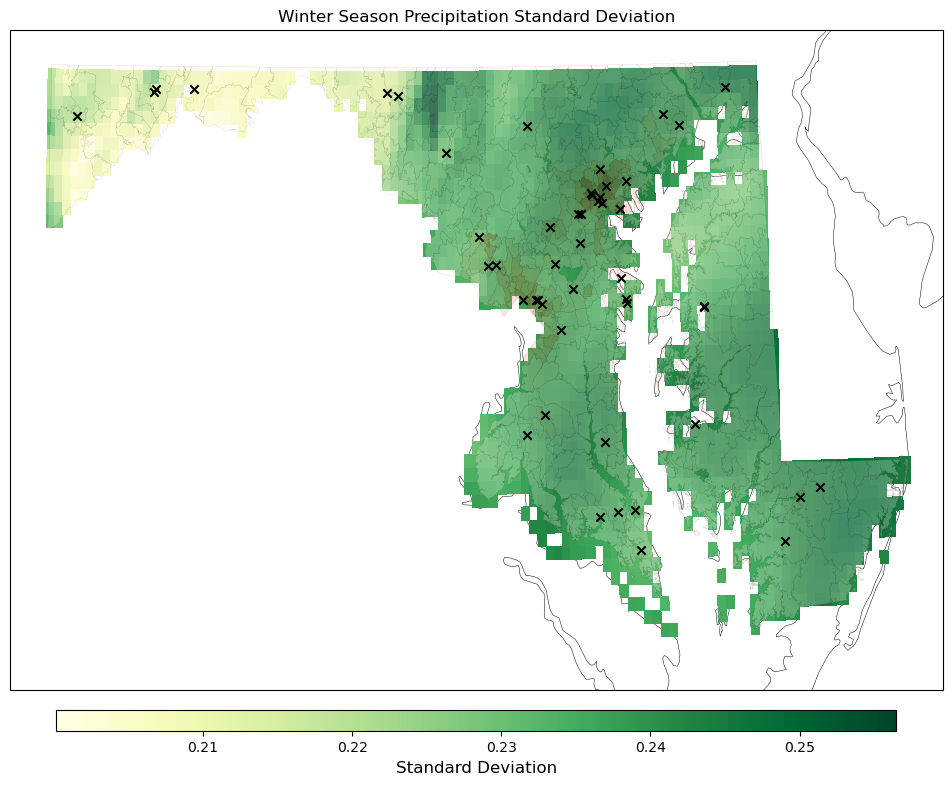

In [14]:
# winter pcp std + norm pop
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Winter Season Precipitation Standard Deviation', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   ds_win.where(md_state_mask==1).values, 
                   vmin=ds_win.where(md_state_mask==1).min(skipna=True).values, 
                   vmax=ds_win.where(md_state_mask==1).max(skipna=True).values, 
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=2)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='popnormbyarea', cmap='Reds', 
                    legend=False, edgecolor='k', lw=0.15, alpha=0.25,
                    figsize=(12,8), vmin=0, vmax=5, zorder=100)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Standard Deviation', fontsize=12)

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

for i, j in zip(md_schools['longitude'].values,
                md_schools['latitude'].values):
    ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k')

plt.savefig('/Users/molina/Desktop/pcpstd_win-popnorm.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


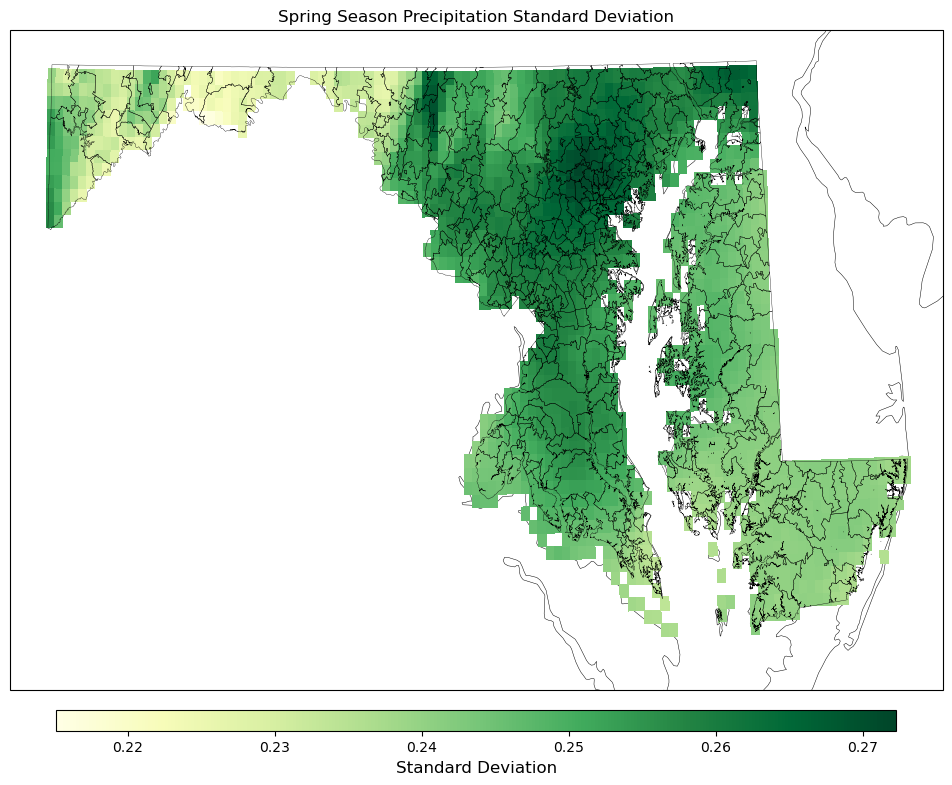

In [15]:
# spring pcp std
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Spring Season Precipitation Standard Deviation', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   ds_spr.where(md_state_mask==1).values, 
                   vmin=ds_spr.where(md_state_mask==1).min(skipna=True).values, 
                   vmax=ds_spr.where(md_state_mask==1).max(skipna=True).values, 
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=10)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Standard Deviation', fontsize=12)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=True, facecolor='none', edgecolor='k', lw=0.25, zorder=100)

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
#ax.add_feature(states10, facecolor='none', edgecolor='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/pcpstd_spr.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


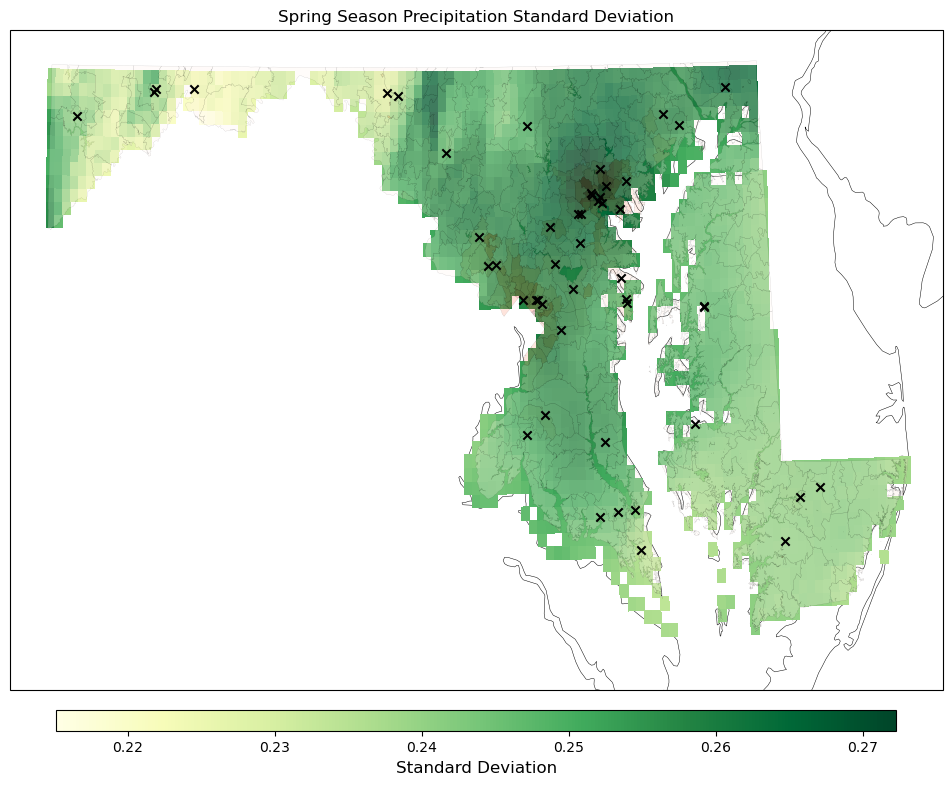

In [16]:
# spring pcp std + norm pop
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Spring Season Precipitation Standard Deviation', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   ds_spr.where(md_state_mask==1).values, 
                   vmin=ds_spr.where(md_state_mask==1).min(skipna=True).values, 
                   vmax=ds_spr.where(md_state_mask==1).max(skipna=True).values, 
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=2)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='popnormbyarea', cmap='Reds', 
                    legend=False, edgecolor='k', lw=0.15, alpha=0.25,
                    figsize=(12,8), vmin=0, vmax=5, zorder=100)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Standard Deviation', fontsize=12)

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

for i, j in zip(md_schools['longitude'].values,
                md_schools['latitude'].values):
    ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k')

plt.savefig('/Users/molina/Desktop/pcpstd_spr-popnorm.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


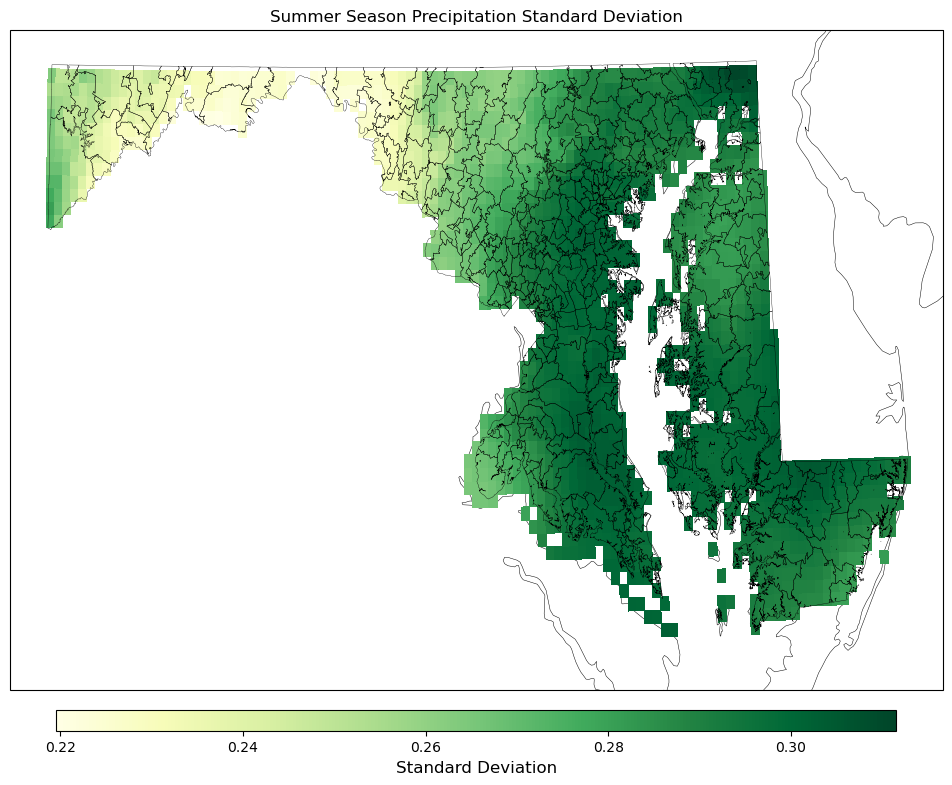

In [17]:
# summer pcp std
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Summer Season Precipitation Standard Deviation', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   ds_sum.where(md_state_mask==1).values, 
                   vmin=ds_sum.where(md_state_mask==1).min(skipna=True).values, 
                   vmax=ds_sum.where(md_state_mask==1).max(skipna=True).values, 
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=10)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Standard Deviation', fontsize=12)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=True, facecolor='none', edgecolor='k', lw=0.25, zorder=100)

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
#ax.add_feature(states10, facecolor='none', edgecolor='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/pcpstd_sum.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


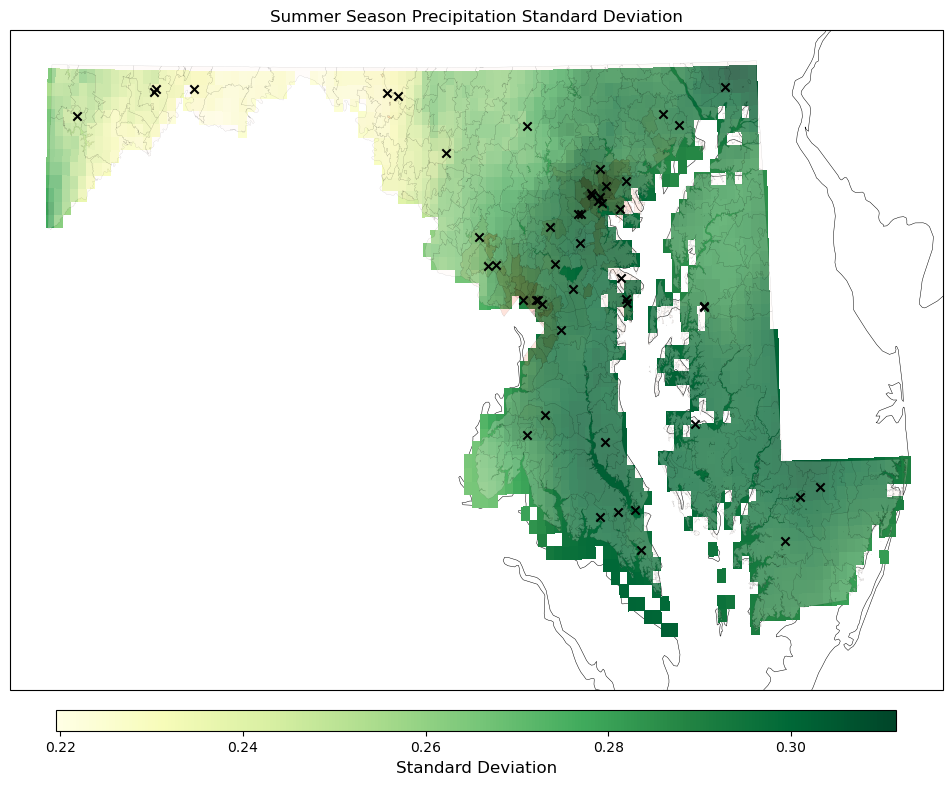

In [18]:
# summer pcp std + norm pop
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Summer Season Precipitation Standard Deviation', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   ds_sum.where(md_state_mask==1).values, 
                   vmin=ds_sum.where(md_state_mask==1).min(skipna=True).values, 
                   vmax=ds_sum.where(md_state_mask==1).max(skipna=True).values, 
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=2)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='popnormbyarea', cmap='Reds', 
                    legend=False, edgecolor='k', lw=0.15, alpha=0.25,
                    figsize=(12,8), vmin=0, vmax=5, zorder=100)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Standard Deviation', fontsize=12)

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

for i, j in zip(md_schools['longitude'].values,
                md_schools['latitude'].values):
    ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k')

plt.savefig('/Users/molina/Desktop/pcpstd_sum-popnorm.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


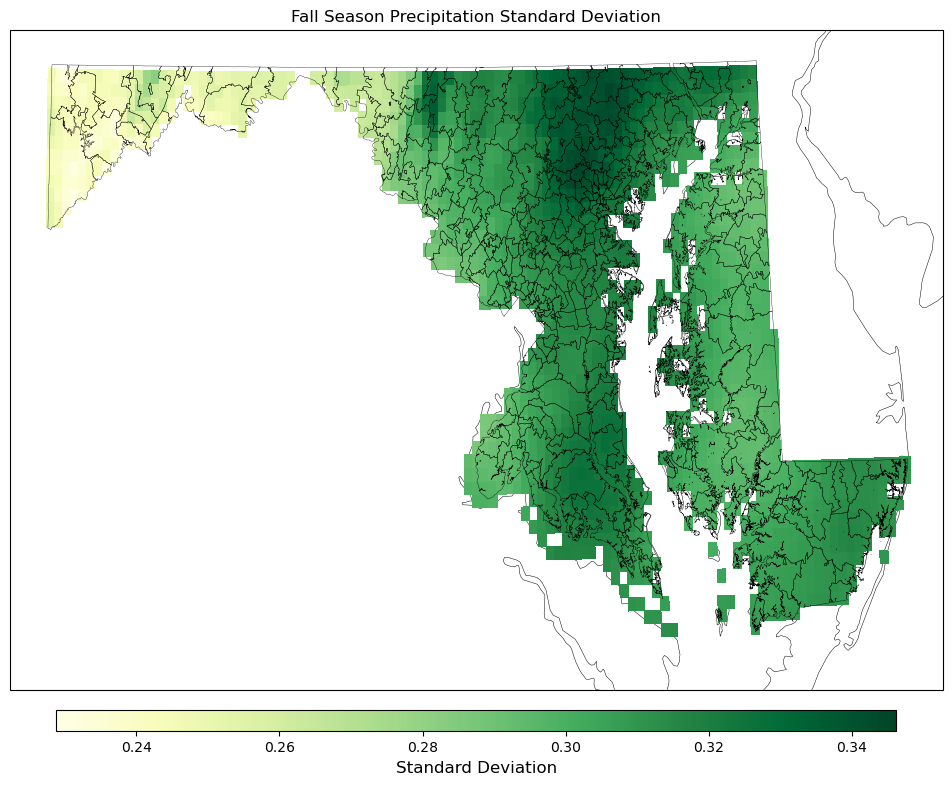

In [19]:
# fall pcp std
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Fall Season Precipitation Standard Deviation', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   ds_fal.where(md_state_mask==1).values, 
                   vmin=ds_fal.where(md_state_mask==1).min(skipna=True).values, 
                   vmax=ds_fal.where(md_state_mask==1).max(skipna=True).values, 
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=10)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Standard Deviation', fontsize=12)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=True, facecolor='none', edgecolor='k', lw=0.25, zorder=100)

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/pcpstd_fal.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


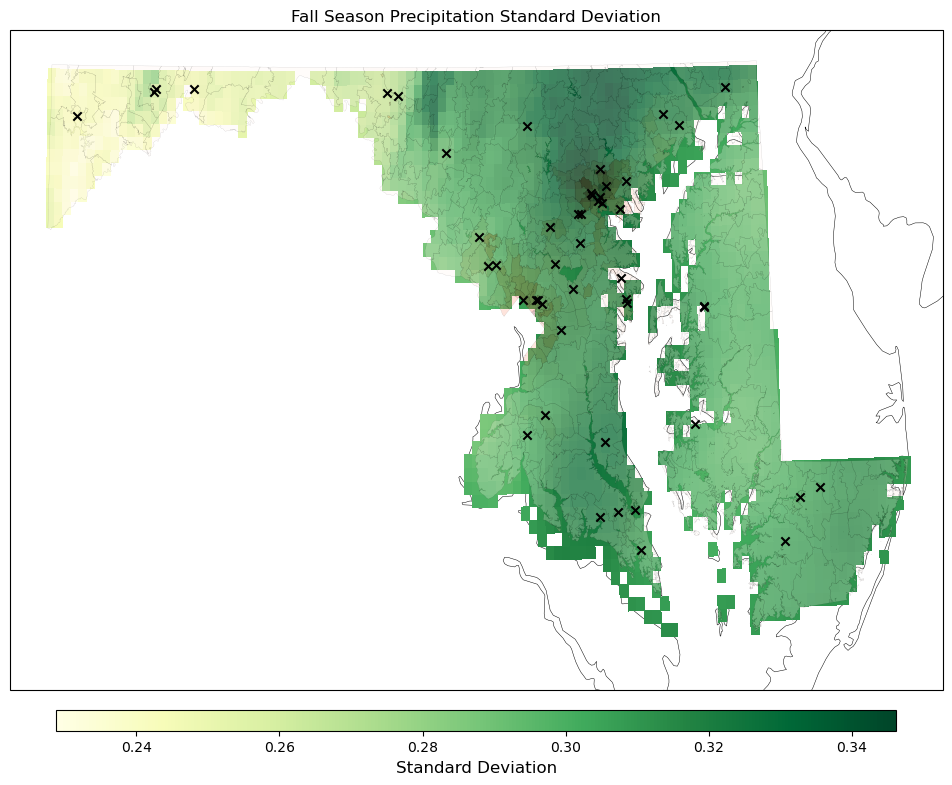

In [20]:
# fall pcp std + norm pop
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Fall Season Precipitation Standard Deviation', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   ds_fal.where(md_state_mask==1).values, 
                   vmin=ds_fal.where(md_state_mask==1).min(skipna=True).values, 
                   vmax=ds_fal.where(md_state_mask==1).max(skipna=True).values, 
                   cmap='YlGn',
                   transform=ccrs.PlateCarree(), zorder=2)

md_zcta_census.plot(ax=ax, transform=ccrs.PlateCarree(), column='popnormbyarea', cmap='Reds', 
                    legend=False, edgecolor='k', lw=0.15, alpha=0.25,
                    figsize=(12,8), vmin=0, vmax=5, zorder=100)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Standard Deviation', fontsize=12)

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

for i, j in zip(md_schools['longitude'].values,
                md_schools['latitude'].values):
    ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k')

plt.savefig('/Users/molina/Desktop/pcpstd_fal-popnorm.png', bbox_inches='tight', dpi=200)
plt.show()

## other demo

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


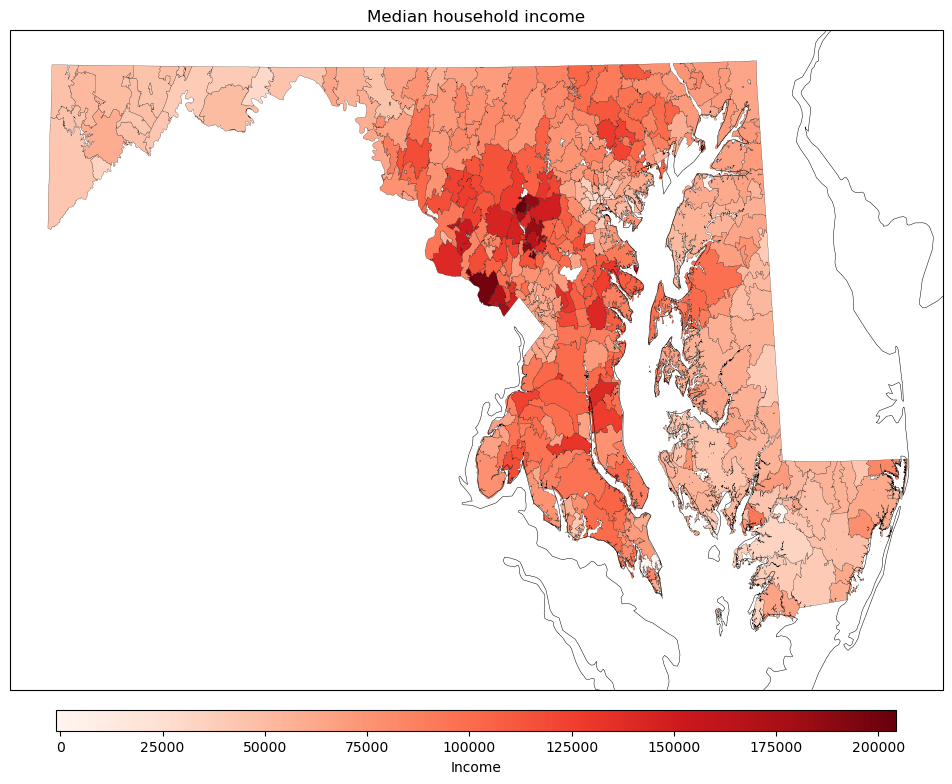

In [21]:
# median household income
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Median household income', fontsize=12)

md_acs.plot(ax=ax, transform=ccrs.PlateCarree(), column='MEDHHINC', cmap='Reds', 
                    legend=True, edgecolor='k', lw=0.15, figsize=(12,8),
                    legend_kwds={'label': 'Income', "orientation": "horizontal",
                                 'shrink':0.7, 'pad':0.025, 'aspect':40})

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/medhhinc_md.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/molina/opt/anaconda3/envs/geo-fiona/lib/python3.7/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


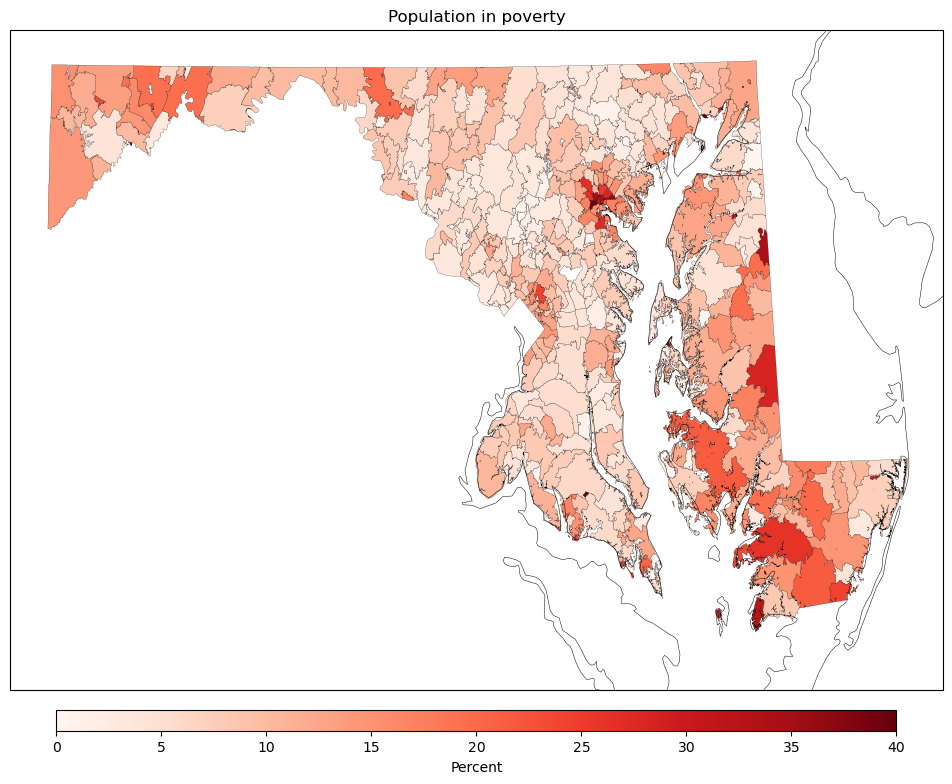

In [22]:
# percent of population in poverty
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Population in poverty', fontsize=12)

md_acs.plot(ax=ax, transform=ccrs.PlateCarree(), column='POV_POP', cmap='Reds', 
                    legend=True, edgecolor='k', lw=0.15, figsize=(12,8), vmin=0, vmax=40,
                    legend_kwds={'label': 'Percent', "orientation": "horizontal",
                                 'shrink':0.7, 'pad':0.025, 'aspect':40})

ax.coastlines(resolution='10m', facecolor='none', color='k', linewidth=0.35, zorder=1)
ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

plt.savefig('/Users/molina/Desktop/povpop_md.png', bbox_inches='tight', dpi=200)
plt.show()

# regrid shapefile data for index creation

In [23]:
# normalized population
md_popnorm_grid = np.zeros((ds_win.shape[0],ds_win.shape[1]))

for i, j in product(range(ds_win.shape[0]),range(ds_win.shape[1])):
    
    if np.isnan(ds_win[i,j].values):
        
        md_popnorm_grid[i,j] = np.nan
        
    if ~np.isnan(ds_win[i,j].values):
        
        for num, k in enumerate(md_zcta_census.contains(Point(ds_win.lon[j].values, ds_win.lat[i].values))):
            
            if k:
                md_popnorm_grid[i,j] = md_zcta_census['popnormbyarea'].iloc[num]

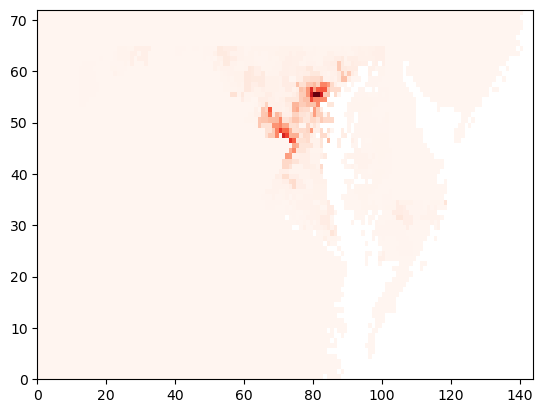

In [24]:
plt.pcolormesh(md_popnorm_grid, cmap='Reds', vmin=0, vmax=5)

In [25]:
# median household income
md_medhhinc_grid = np.zeros((ds_win.shape[0],ds_win.shape[1]))

for i, j in product(range(ds_win.shape[0]),range(ds_win.shape[1])):
    
    if np.isnan(ds_win[i,j].values):
        
        md_medhhinc_grid[i,j] = np.nan
        
    if ~np.isnan(ds_win[i,j].values):
        
        for num, k in enumerate(md_acs.contains(Point(ds_win.lon[j].values, ds_win.lat[i].values))):
            
            if k:
                md_medhhinc_grid[i,j] = md_acs['MEDHHINC'].iloc[num]

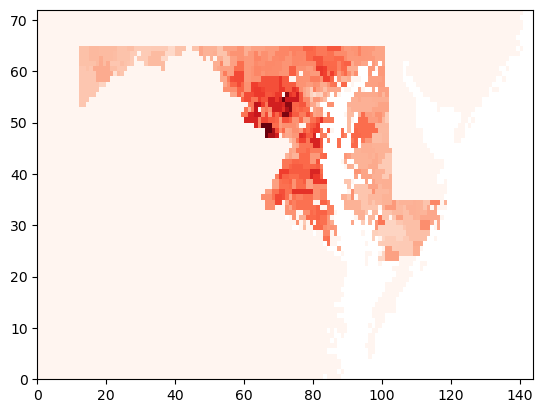

In [26]:
plt.pcolormesh(md_medhhinc_grid, cmap='Reds', vmin=0, vmax=200000)

In [27]:
# percent living in poverty
md_povpoc_grid = np.zeros((ds_win.shape[0],ds_win.shape[1]))

for i, j in product(range(ds_win.shape[0]),range(ds_win.shape[1])):
    
    if np.isnan(ds_win[i,j].values):
        
        md_povpoc_grid[i,j] = np.nan
        
    if ~np.isnan(ds_win[i,j].values):
        
        for num, k in enumerate(md_acs.contains(Point(ds_win.lon[j].values, ds_win.lat[i].values))):
            
            if k:
                md_povpoc_grid[i,j] = md_acs['POV_POP'].iloc[num]

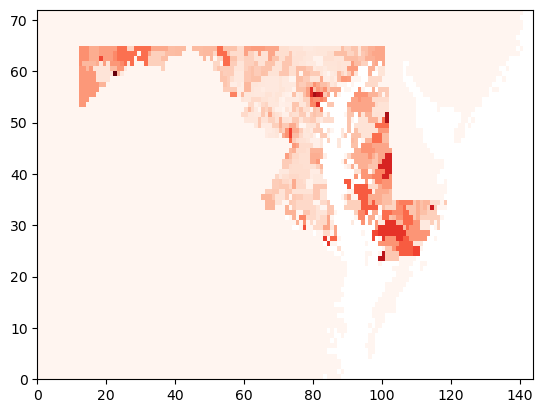

In [28]:
plt.pcolormesh(md_povpoc_grid, cmap='Reds', vmin=0, vmax=40)

## data exploration

(array([ 39.,  86.,  50.,  32.,  26., 288., 429., 401., 147.,  87.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

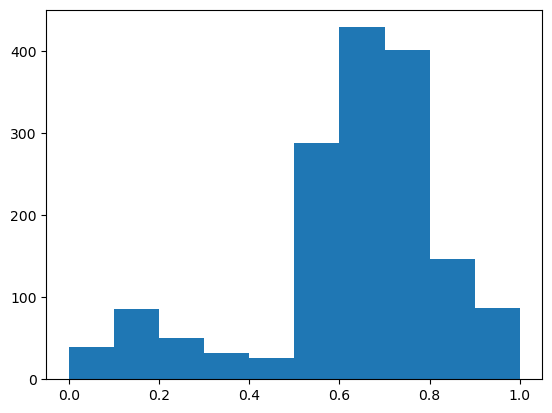

In [29]:
tmp = minmaxscale(ds_fal.where(md_state_mask==1).values).flatten()
plt.hist(tmp[~np.isnan(tmp)])

(array([1.318e+03, 9.900e+01, 2.800e+01, 1.500e+01, 9.000e+00, 5.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([2.57719498e-04, 1.00231948e-01, 2.00206176e-01, 3.00180404e-01,
        4.00154632e-01, 5.00128860e-01, 6.00103088e-01, 7.00077316e-01,
        8.00051544e-01, 9.00025772e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

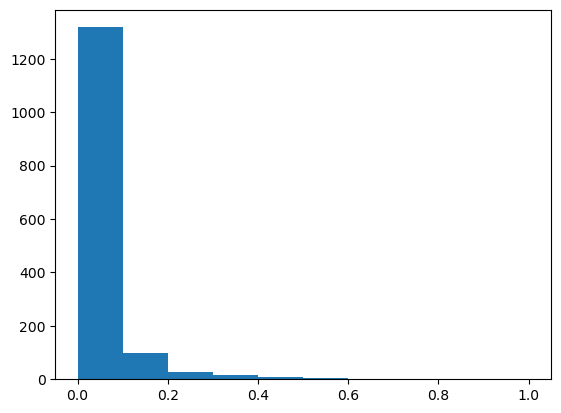

In [30]:
tmp = minmaxscale(md_popnorm_grid).flatten()

tmp2 = tmp[(~np.isnan(tmp))]
tmp2 = tmp2[(tmp2!=0.0)]

plt.hist(tmp2)

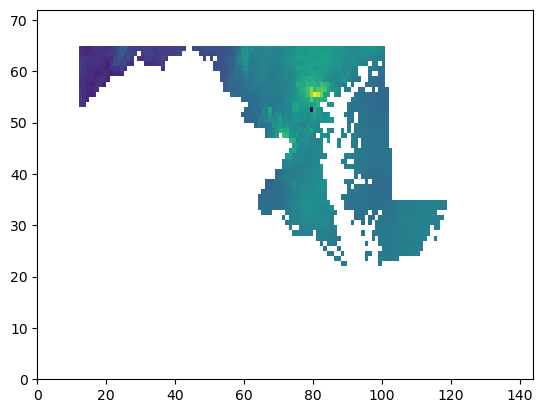

In [31]:
plt.pcolormesh(
    minmaxscale(
        ds_fal.where(md_state_mask==1).values) + minmaxscale(
        md_popnorm_grid) + minmaxscale(
        md_povpoc_grid))

## index plotting / creation

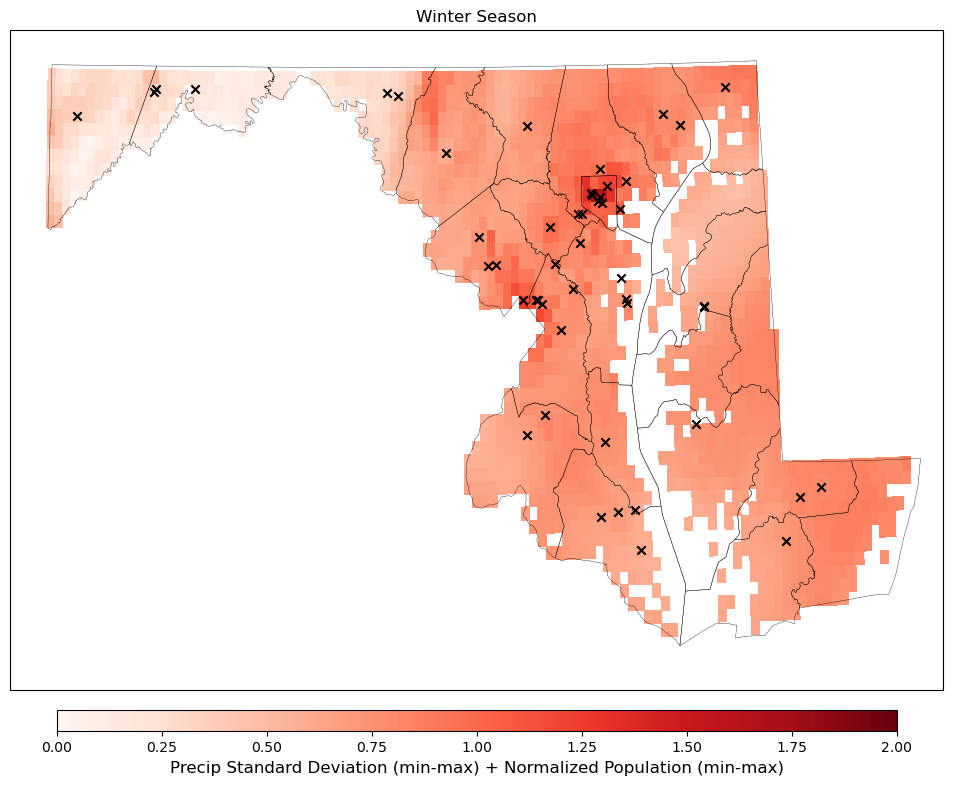

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Winter Season', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   minmaxscale(ds_win.where(md_state_mask==1).values) + minmaxscale(md_popnorm_grid), 
                   cmap='Reds', vmin=0, vmax=2,
                   transform=ccrs.PlateCarree(), zorder=10)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Precip Standard Deviation (min-max) + Normalized Population (min-max)', fontsize=12)

md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=True, facecolor='none', edgecolor='k', lw=0.25, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

for i, j in zip(md_schools['longitude'].values,
                md_schools['latitude'].values):
    ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k')

plt.savefig('/Users/molina/Desktop/pcpstdpop_win.png', bbox_inches='tight', dpi=200)
plt.show()

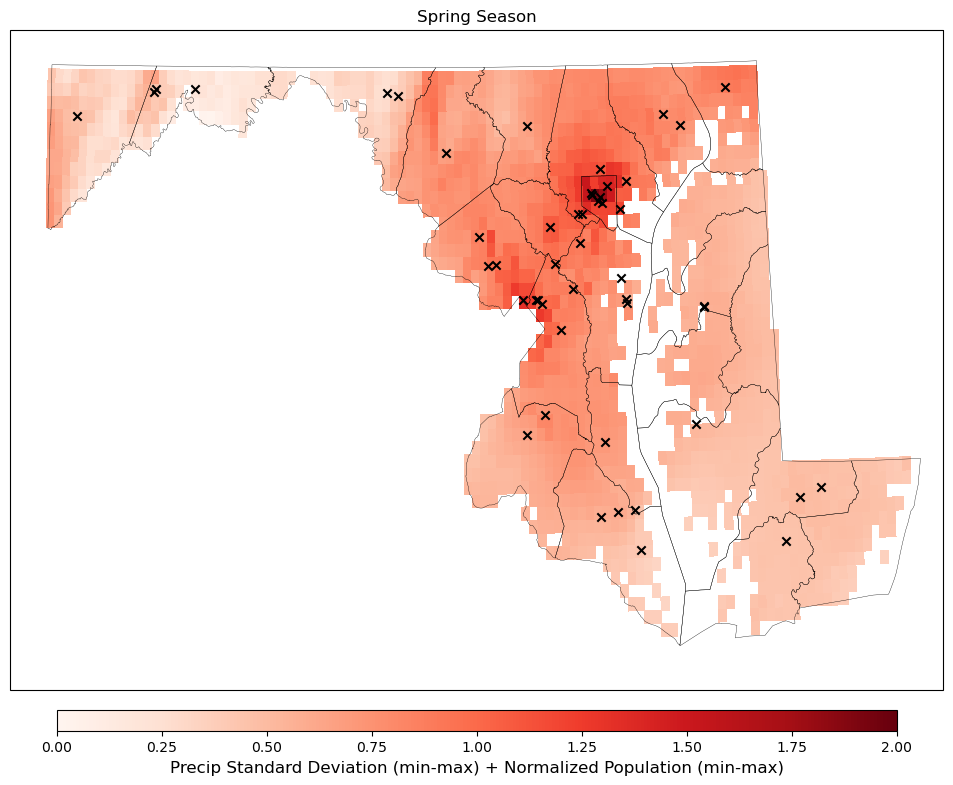

In [33]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Spring Season', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   minmaxscale(ds_spr.where(md_state_mask==1).values) + minmaxscale(md_popnorm_grid), 
                   cmap='Reds', vmin=0, vmax=2,
                   transform=ccrs.PlateCarree(), zorder=10)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Precip Standard Deviation (min-max) + Normalized Population (min-max)', fontsize=12)

md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=True, facecolor='none', edgecolor='k', lw=0.25, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

for i, j in zip(md_schools['longitude'].values,
                md_schools['latitude'].values):
    ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k')

plt.savefig('/Users/molina/Desktop/pcpstdpop_spr.png', bbox_inches='tight', dpi=200)
plt.show()

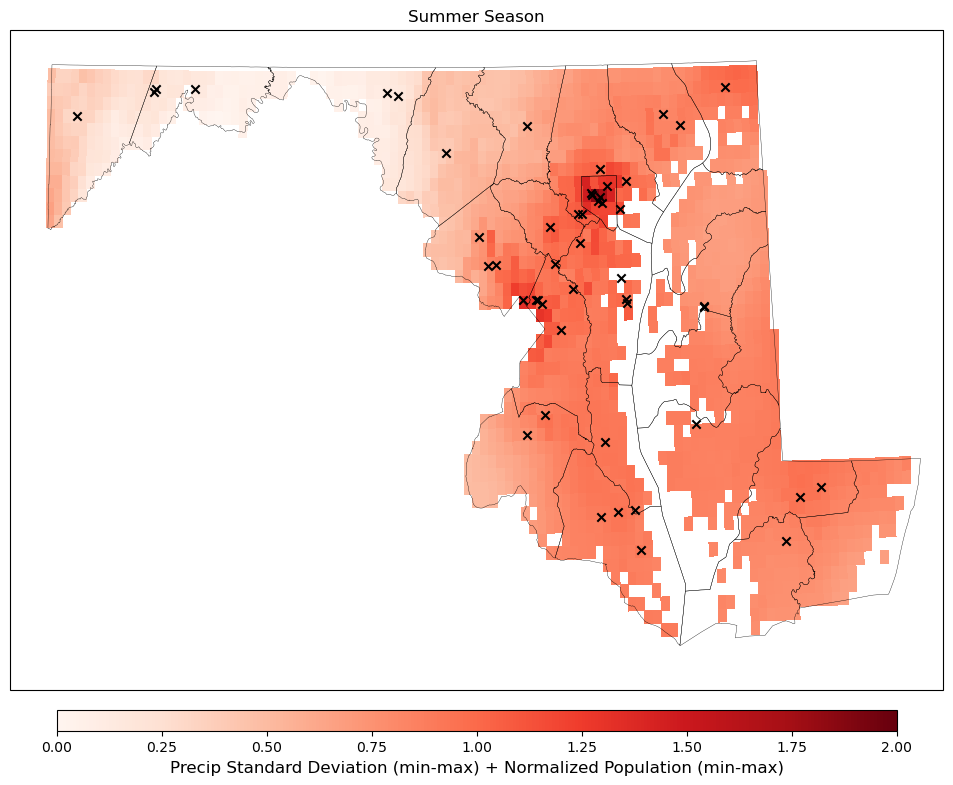

In [34]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Summer Season', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   minmaxscale(ds_sum.where(md_state_mask==1).values) + minmaxscale(md_popnorm_grid), 
                   cmap='Reds', vmin=0, vmax=2,
                   transform=ccrs.PlateCarree(), zorder=10)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Precip Standard Deviation (min-max) + Normalized Population (min-max)', fontsize=12)

md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=True, facecolor='none', edgecolor='k', lw=0.25, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

for i, j in zip(md_schools['longitude'].values,
                md_schools['latitude'].values):
    ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k')

plt.savefig('/Users/molina/Desktop/pcpstdpop_sum.png', bbox_inches='tight', dpi=200)
plt.show()

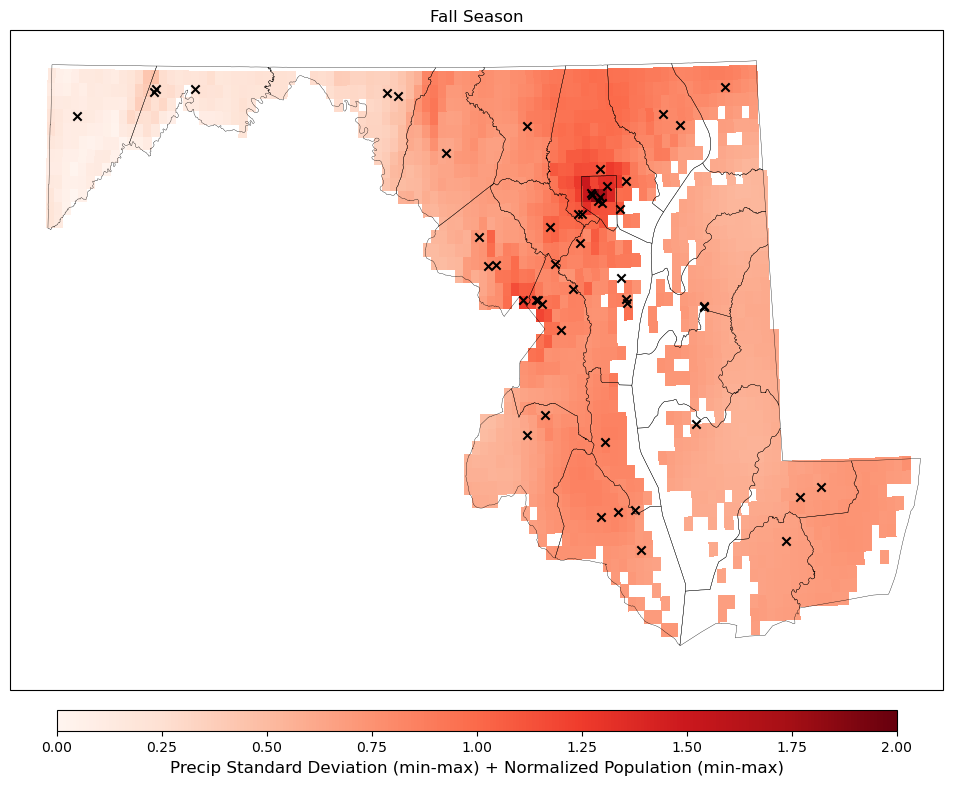

In [35]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_longitude=-78.0, central_latitude=35.0))

ax.set_title('Fall Season', fontsize=12)

pc = ax.pcolormesh(ds_win.lon, ds_win.lat, 
                   minmaxscale(ds_fal.where(md_state_mask==1).values) + minmaxscale(md_popnorm_grid), 
                   cmap='Reds', vmin=0, vmax=2,
                   transform=ccrs.PlateCarree(), zorder=10)

cbar = fig.colorbar(pc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.025, aspect=40)
cbar.set_label('Precip Standard Deviation (min-max) + Normalized Population (min-max)', fontsize=12)

md_counties.plot(ax=ax, transform=ccrs.PlateCarree(), 
                    legend=True, facecolor='none', edgecolor='k', lw=0.25, zorder=100)

ax.set_extent([-79.65, -74.9, 37.75, 39.8], crs=ccrs.PlateCarree())

for i, j in zip(md_schools['longitude'].values,
                md_schools['latitude'].values):
    ax.scatter(i, j, transform=ccrs.PlateCarree(), zorder=1000, marker='x', color='k')

plt.savefig('/Users/molina/Desktop/pcpstdpop_fal.png', bbox_inches='tight', dpi=200)
plt.show()